# Mini Project 2 - DL Skills - Modeling

## Import libraries and load data

In [1]:
import tensorflow as tf
from utils import get_prepared_data

2021-08-06 18:00:53.118420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-06 18:00:53.118442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(x_train, x_test), (y_train, y_test) = get_prepared_data()

In [3]:
batch_size = 16

# https://www.tensorflow.org/tutorials/load_data/numpy
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(50000, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(10000, reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)

2021-08-06 18:01:06.497346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-06 18:01:06.497391: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-06 18:01:06.497423: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivankras-ThinkPad-X1-Yoga-1st): /proc/driver/nvidia/version does not exist
2021-08-06 18:01:06.499185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model Network

In [4]:
import keras
from keras.models import Sequential
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Flatten
)

### Model: simplified VGG

In [5]:
model = Sequential()

conv_layer_1 = Conv2D(
    batch_input_shape=(batch_size, 32, 32, 1), # TODO
    filters=32,        # number of outputs
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',    # maintain shape
    activation='relu'
)
model.add(conv_layer_1)

conv_layer_2 = Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'
)
model.add(conv_layer_2)

poolA = MaxPool2D((2, 2), strides=(2,2))
model.add(poolA)

conv_layer_3 = Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'
)
conv_layer_3b = Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'
)
model.add(conv_layer_3)
model.add(conv_layer_3b)

poolB = MaxPool2D((2, 2), strides=(2,2))
model.add(poolB)

conv_layer_4 = Conv2D(
    filters=128,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'
)
conv_layer_4b = Conv2D(
    filters=128,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'
)
model.add(conv_layer_4)
model.add(conv_layer_4b)

poolC = MaxPool2D((2, 2), strides=(2,2))
model.add(poolC)


dense_layer = Dense(units=128, activation='relu')
softmax = Dense(units=10, activation='softmax')

model.add(Flatten())
model.add(dense_layer)
model.add(softmax)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (16, 32, 32, 32)          320       
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 32, 32, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 16, 16, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 16, 16, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (16, 16, 16, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 8, 8, 64)            0         
_________________________________________________________________
conv2d_4 (Conv2D)            (16, 8, 8, 128)           7

In [6]:
from keras.optimizers import adam_v2

opt = adam_v2.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

model.compile(
    optimizer=opt,
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [7]:
from keras.callbacks import (ModelCheckpoint, EarlyStopping)
checkpoint = ModelCheckpoint(
    "updated_vgg.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit(
    x=train_dataset,
    steps_per_epoch=100,
    validation_data=test_dataset,
    validation_steps=10,
    epochs=100,
    callbacks=[checkpoint, early]
)

Epoch 1/40


2021-08-06 18:01:41.929626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-06 18:01:41.950449: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2799925000 Hz


100/100 [==============================] - 30s 96ms/step - loss: 3.7231 - accuracy: 0.1018 - val_loss: 2.2628 - val_accuracy: 0.1500
Epoch 2/40
100/100 [==============================] - 7s 70ms/step - loss: 2.1798 - accuracy: 0.1870 - val_loss: 2.0151 - val_accuracy: 0.2500
Epoch 3/40
100/100 [==============================] - 7s 67ms/step - loss: 2.0120 - accuracy: 0.2433 - val_loss: 2.0684 - val_accuracy: 0.2375
Epoch 4/40
100/100 [==============================] - 7s 75ms/step - loss: 1.9274 - accuracy: 0.2822 - val_loss: 1.7113 - val_accuracy: 0.3812
Epoch 5/40
100/100 [==============================] - 9s 95ms/step - loss: 1.8566 - accuracy: 0.3231 - val_loss: 1.8539 - val_accuracy: 0.2562
Epoch 6/40
100/100 [==============================] - 8s 81ms/step - loss: 1.7575 - accuracy: 0.3181 - val_loss: 1.9413 - val_accuracy: 0.2438
Epoch 7/40
100/100 [==============================] - 8s 81ms/step - loss: 1.7430 - accuracy: 0.3976 - val_loss: 1.6593 - val_accuracy: 0.4187
Epoch 8/4

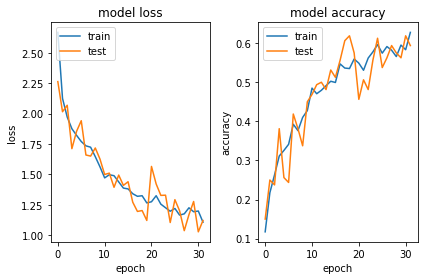

In [8]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(hist.history["loss"])
ax1.plot(hist.history["val_loss"])
ax1.set_title("model loss")
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.legend(["train", "test"], loc="upper left")

ax2.plot(hist.history["accuracy"])
ax2.plot(hist.history["val_accuracy"])
ax2.set_title("model accuracy")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("epoch")
ax2.legend(["train", "test"], loc="upper left")

fig.tight_layout()
plt.show()

### Predictions

In [22]:
y_hat = model.predict(x_test)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0.00973341 0.00099683 0.13823715 0.10842919 0.41729394 0.19692977
 0.0622964  0.05702534 0.00698752 0.00207045]


Matches: 6182 out of 10000
Best estimation (7) confidence: 1.0
horse
Best estimation (7) confidence: 0.851071298122406
horse


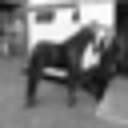

In [33]:
import numpy as np
from PIL import Image

def get_category(y, verbose=False):
    i2Cat = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

    best_est_idx = np.argmax(y)
    if verbose:
        print(f'Best estimation ({best_est_idx}) confidence: {y[best_est_idx]}')
    return i2Cat[best_est_idx]

# Recheck accuracy calculation on test set
count = 0
for i in range(len(y_test)):
    if np.argmax(y_test[i]) == np.argmax(y_hat[i]):
        count += 1
print(f'Matches: {count} out of {len(y_test)}')

test_idx = 20
print(get_category(y_test[test_idx], verbose=True))
print(get_category(y_hat[test_idx], verbose=True))
Image.fromarray(x_test[test_idx].reshape(32, 32)).resize((128, 128))